# Explicación de PCA

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Octubre de 2024  
**Versión:** 1.0  

---

## Descripción

Este notebook muestra la aplicación de PCA para reducción de la dimensionalidad

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)
- matplotlib (3.7.1)
- seaborn (0.13.1)
- sklearn (1.3.2)

# Funcionamiento

Utiliza un archivo csv , en el cual se decide si convenía alquilar o comprar casa dadas 9 dimensiones.

En este ejemplo:

*   Se normalizan los datos de entrada,
*   Se aplica PCA

Además, se verá que con 5 de las nuevas dimensiones (y descartando 4) se obtendrá hasta un 85% de variación explicada y buenas predicciones.



---



Se generan 2 gráficas:
+ Una con el acumulado de variabilidad explicada y
+ Una gráfica 2D, en donde el eje X e Y serán los 2 primeros componentes principales obtenidos por PCA.



---



Finalmente, se verá cómo los resultados “comprar o alquilar” tienen bastante buena separación en 2 dimensiones.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

# Carga datos

In [ ]:
!wget https://raw.githubusercontent.com/JaznaLaProfe/Fundamentos-de-Machine-Learning/main/data/comprar_alquiler.csv

--2024-10-26 23:00:37--  https://raw.githubusercontent.com/JaznaLaProfe/Fundamentos-de-Machine-Learning/main/data/comprar_alquiler.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8019 (7.8K) [text/plain]
Saving to: ‘comprar_alquiler.csv’

comprar_alquiler.cs 100%[===================>]   7.83K  --.-KB/s    in 0s      

2024-10-26 23:00:37 (57.3 MB/s) - ‘comprar_alquiler.csv’ saved [8019/8019]



# Diccionario de datos

+ ingresos y gastos son mensuales de 1 personas o 2 si están casados.
+ trabajo: 0-sin trabajo 1-autonomo 2-asalariado 3-empresario 4-Autonomos 5-Asalariados 6-Autonomo y Asalariado 7-Empresario y Autonomo 8 Empresarios o empresario y autónomo
+ estado_civil: 0-soltero 1-casado 2-divorciado
+ hijos: Cantidad de hijos menores (no trabajan)
+ comprar: 0-mejor alquilar 1-Comprar casa
+ hipoteca fija a 30 años con interes

In [ ]:
# Carga de la data
data = pd.read_csv(r"comprar_alquiler.csv")
data.head(10)

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1
5,5692,911,11,325,50875,360863,1,4,5,1
6,6830,1298,345,309,46761,429812,1,1,5,1
7,6470,1035,39,782,57439,606291,0,0,1,0
8,6251,1250,209,571,50503,291010,0,0,3,1
9,6987,1258,252,245,40611,324098,2,1,7,1


# Visualización de las dimensiones

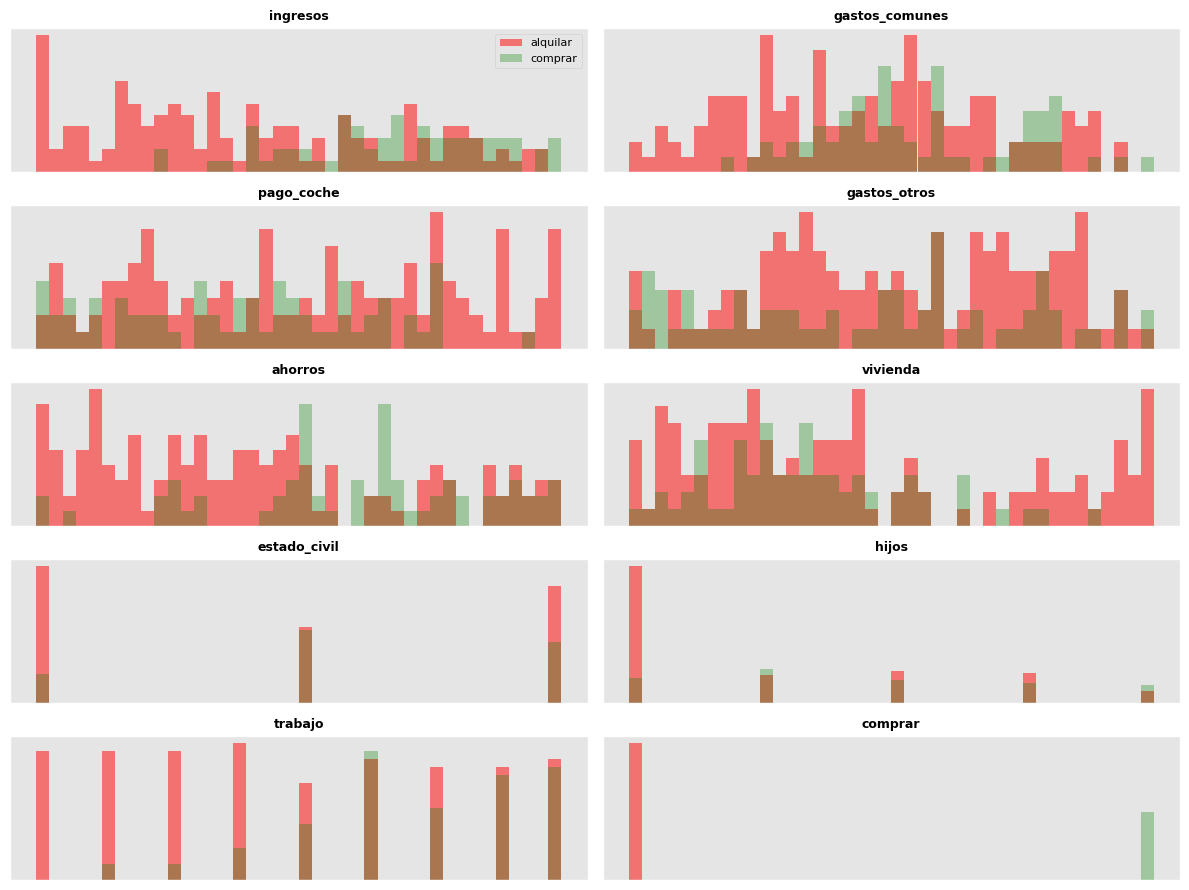

In [ ]:
fig,axes = plt.subplots(5,2, figsize=(12, 9)) # 2 columnas cada una con 5 figuras, total 10 features
alquilar=data[data['comprar']==0] # conviene alquilar casa
comprar=data[data['comprar']==1] # conviene comprar casa
ax=axes.ravel()
for i in range(len(data.columns)):
  _,bins=np.histogram(data[data.columns[i]],bins=40)
  ax[i].hist(alquilar.values[:,i],bins=bins,color='r',alpha=.5)# rojo alquilar
  ax[i].hist(comprar.values[:,i],bins=bins,color='g',alpha=0.3)# verde para comprar
  ax[i].set_title(data.columns[i],fontsize=9, fontweight="bold")
  ax[i].axes.get_xaxis().set_visible(False)
  ax[i].set_yticks(())
ax[0].legend(['alquilar','comprar'],loc='best',fontsize=8)
plt.tight_layout()
plt.show()

# Correlación

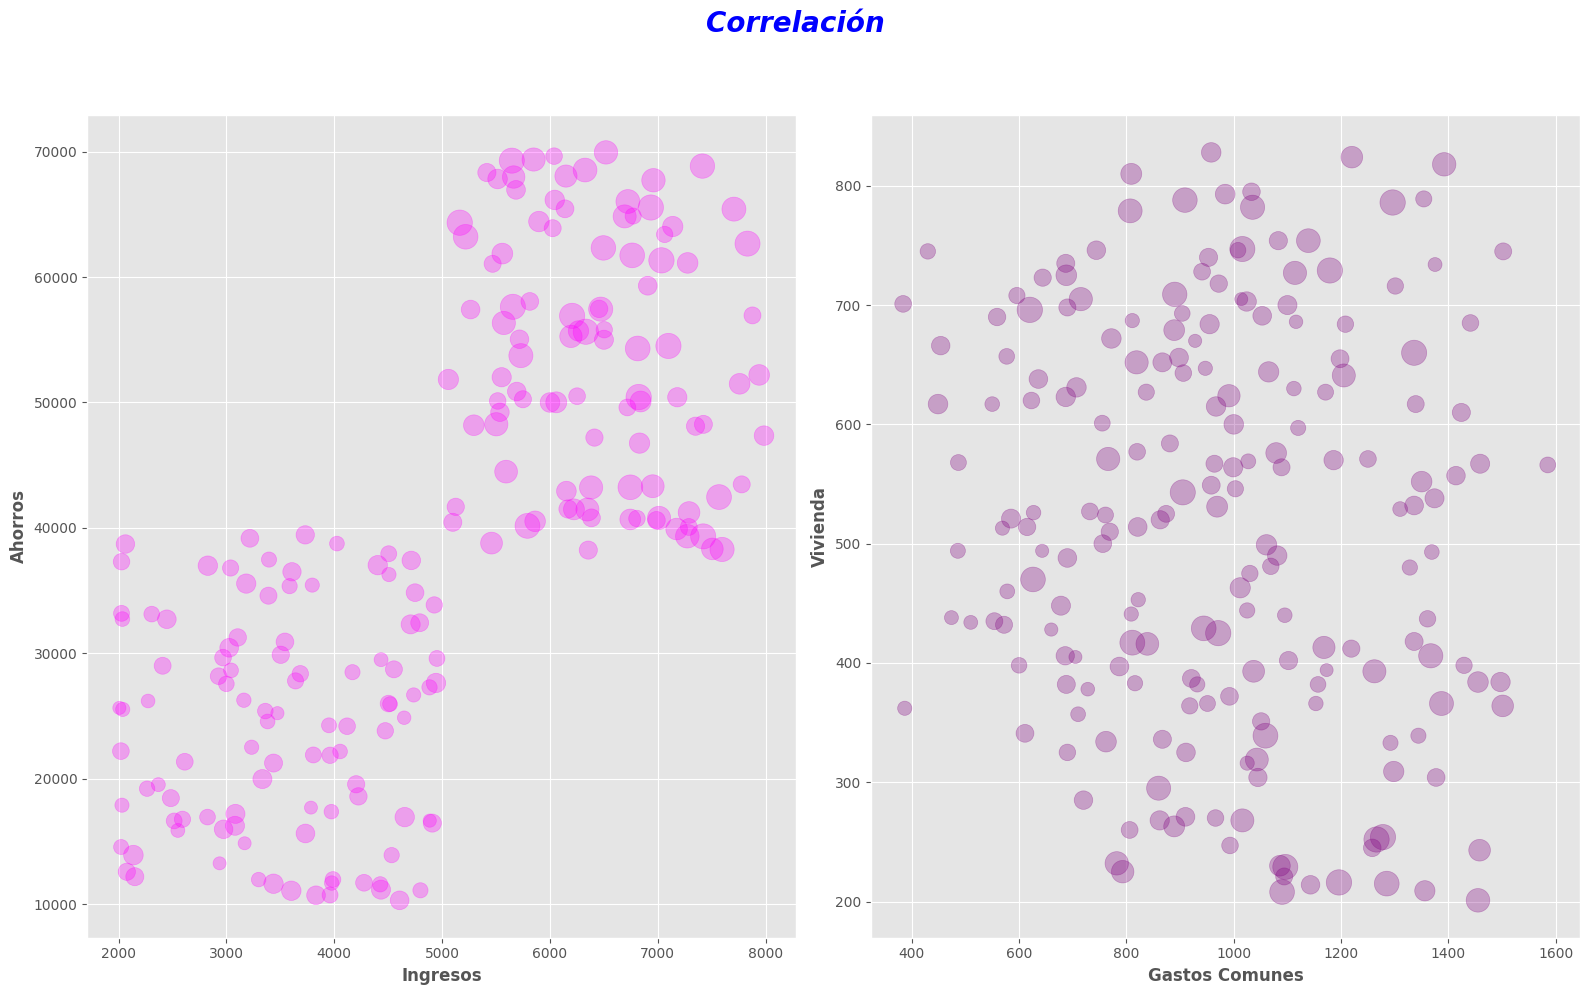

In [ ]:
# Primer gráfico
plt.subplot(1,2,1)
plt.scatter(data['ingresos'], data['ahorros'], s=data['vivienda']*0.0005, color='magenta', label='check', alpha=0.3)
plt.xlabel('Ingresos',fontsize=12, fontweight="bold")
plt.ylabel('Ahorros',fontsize=12, fontweight="bold")
# Segundo gráfico
plt.subplot(1,2,2)
plt.scatter(data['gastos_comunes'], data['gastos_otros'], s=data['vivienda']*0.0005, color='purple', label='check', alpha=0.3)
plt.xlabel('Gastos Comunes',fontsize=12, fontweight="bold")
plt.ylabel('Vivienda',fontsize=12, fontweight="bold")
plt.tight_layout()
plt.suptitle("Correlación", fontsize=20, fontweight="bold", color="blue", y = 1.1, style="italic")
plt.show()

# Escalado de los datos

In [ ]:
# Crea el objeto para escalar
scaler = StandardScaler()
# Selección de los datos para escalar
df = data.drop(['comprar'], axis=1)
# Calcula la media y desviación estándar para cada dimension
scaler.fit(df)
# Transforma los datos a su nueva escala
X_scaled = scaler.transform(df)

# Aplicación de  PCA

In [ ]:
pca = PCA(n_components=9)
# Buscar los componentes principales
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
# Imprime la forma del array
print("shape of X_pca", X_pca.shape)

shape of X_pca (202, 9)


# Predicciones

In [ ]:
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:5]))

[0.29913557 0.23294923 0.11711241 0.10685622 0.09635279 0.05629866
 0.04145579 0.03017819 0.01966115]
suma: 0.852406211771431


---
**Observación**


---


+ Con 5 componentes tenemos algo mas del 85% de varianza explicada

# Gráfica de la variación explicada acumulada

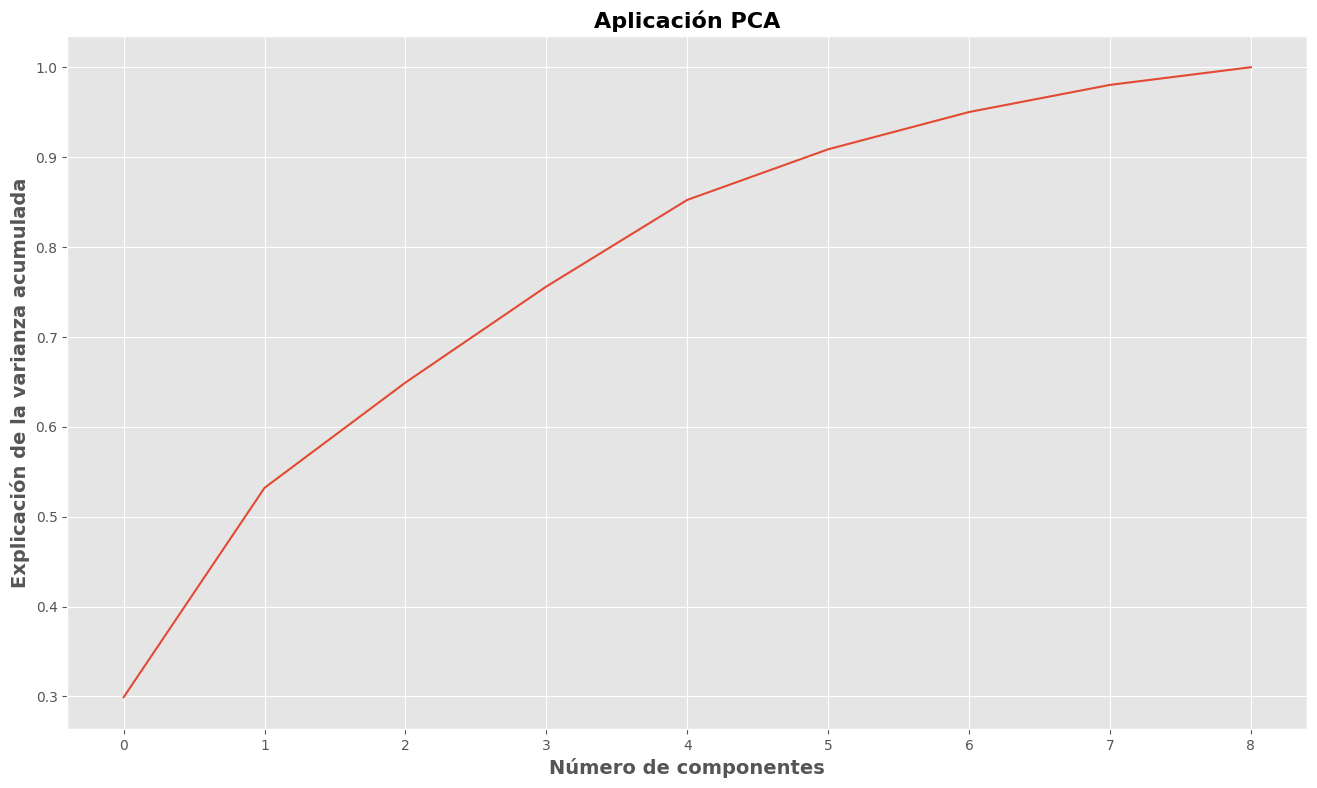

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes', fontsize=14, fontweight="bold")
plt.ylabel('Explicación de la varianza acumulada', fontsize=14, fontweight="bold")
plt.title("Aplicación PCA", fontsize=16, fontweight="bold")
plt.show()

# Gráfica de los 2 componentes principales

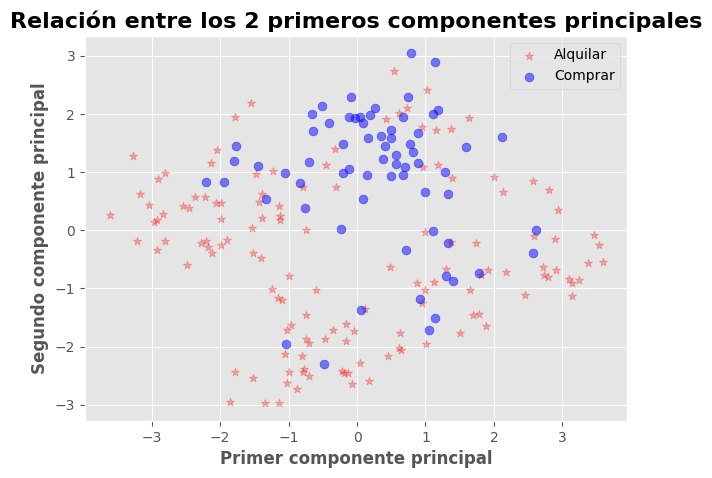

In [ ]:
Xax = X_pca[:,0]
Yax = X_pca[:,1]
labels=data['comprar'].values
cdict={0:'red',1:'blue'}
labl={0:'Alquilar',1:'Comprar'}
marker={0:'*',1:'o'}
alpha={0:.3, 1:.5}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
    ix=np.where(labels==l)
    ax.scatter(Xax[ix],Yax[ix],c=cdict[l],label=labl[l],s=40,marker=marker[l],alpha=alpha[l])

plt.xlabel("Primer componente principal", fontsize=12, fontweight="bold")
plt.ylabel("Segundo componente principal", fontsize=12, fontweight="bold")
plt.legend()
plt.title("Relación entre los 2 primeros componentes principales", fontsize=16, fontweight="bold")
plt.show()

# Correlacion entre las nuevas componentes y las dimensiones originales

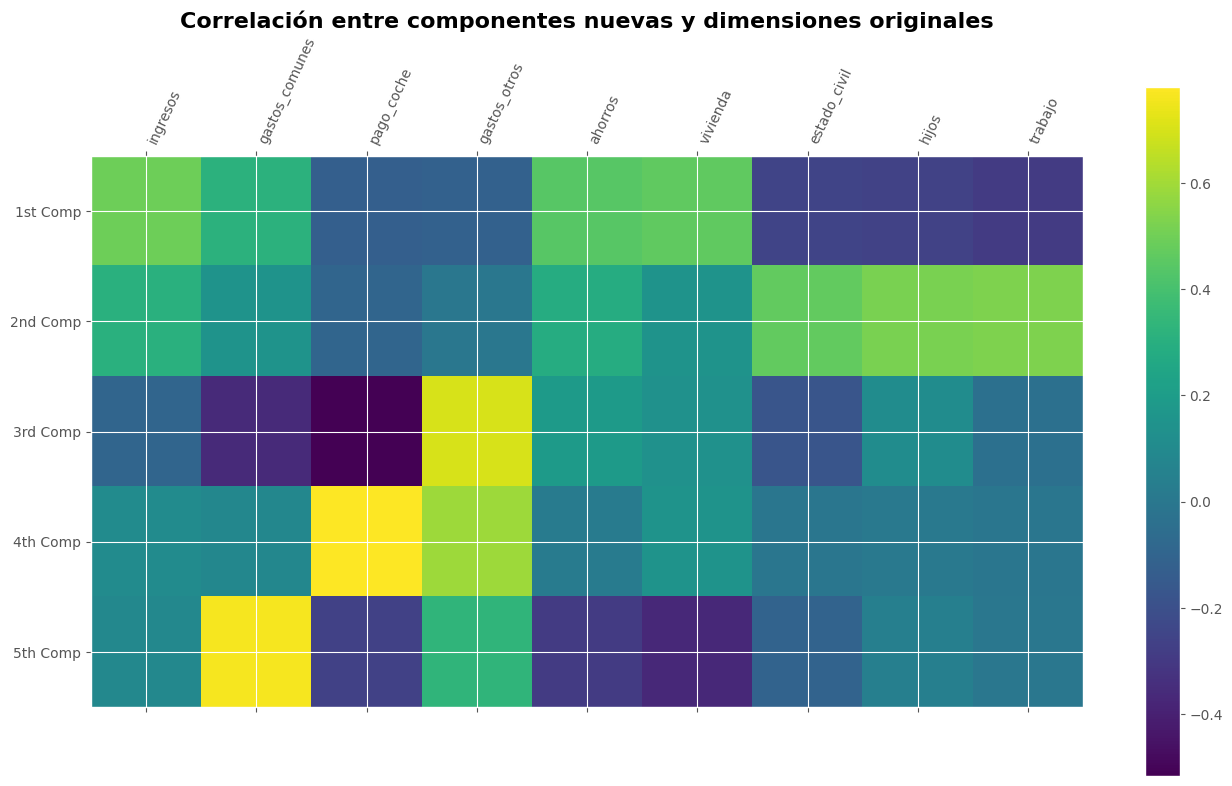

In [ ]:
plt.matshow(pca.components_[0:5],cmap='viridis')
plt.yticks([0,1,2,3,4],['1st Comp','2nd Comp','3rd Comp','4th Comp','5th Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(df.columns)),df.columns,rotation=65,ha='left')
plt.title("Correlación entre componentes nuevas y dimensiones originales", fontsize=16, fontweight="bold")
plt.show()

In [ ]:
components = pd.DataFrame(pca.components_, columns = df.columns)
components

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo
0,0.493720,0.318229,-0.123771,-0.111876,0.444650,0.462609,-0.252279,-0.259859,-0.290248
1,0.306959,0.147373,-0.091641,0.000112,0.288435,0.148985,0.469044,0.521894,0.527156
2,-0.091419,-0.363453,-0.516144,0.701986,0.191767,0.140513,-0.172885,0.112184,-0.036910
3,0.111222,0.081630,0.780268,0.590704,0.022839,0.150085,-0.007663,0.007404,-0.007493
4,0.088897,0.763006,-0.265554,0.330744,-0.289002,-0.365556,-0.104639,0.043668,0.000009
5,-0.075477,0.067903,-0.153697,0.154422,-0.230181,0.290799,0.767070,-0.387964,-0.256446
6,-0.154319,0.105598,-0.027333,-0.101876,-0.524584,0.641034,-0.212365,0.460067,-0.105053
7,-0.012732,0.010274,-0.061759,0.037977,-0.212759,0.260847,-0.204816,-0.532216,0.745630
8,0.776990,-0.374440,-0.048557,0.026631,-0.474168,-0.156101,-0.003289,0.011051,-0.060657


# Validación del algoritmo

In [ ]:
dfScaledPca = pd.DataFrame(X_pca, columns = df.columns)
dfScaledPca["comprar"]=data["comprar"]
print (dfScaledPca.head())
print(dfScaledPca.shape)
# Separación de datos en entrenamiento y test
X_train, X_test = train_test_split(dfScaledPca, test_size=0.2, random_state=29)
y_train = X_train["comprar"]
y_test = X_test["comprar"]
X_train = X_train.drop(['comprar'], axis=1)
X_test = X_test.drop(['comprar'], axis=1)

   ingresos  gastos_comunes  pago_coche  gastos_otros   ahorros  vivienda  \
0  1.321915       -0.222950    1.599863     -0.885014  0.646617 -0.700208   
1  1.147878        1.716967    0.395722     -0.447960 -0.687805 -0.231969   
2  0.090369        1.836066    1.359382      0.337505  0.742387  0.593030   
3  3.455898       -0.078279   -0.202382     -1.573584 -0.068551 -0.051945   
4  0.916933       -1.184676    0.190036      0.117804 -0.147753 -0.619750   

   estado_civil     hijos   trabajo  comprar  
0      0.318031 -0.751809  0.269984        1  
1      1.542487  0.221799  0.438425        0  
2     -1.540495  0.668120  0.153463        1  
3      0.909409  0.684486 -0.129045        0  
4     -0.450419  0.194341  0.687452        1  
(202, 10)


# Predicción con Gaussian Naive Bayes

Con datos de entrada con reducción de dimensiones por PCA

In [ ]:
# Crea el clasificador
model = GaussianNB()
# Entranamiento
model.fit(X_train.values, y_train)
# Predicción
y_pred = model.predict(X_test.values)

# Resultados obtenidos en la prediccón

In [ ]:
print('Precisión en el set de Entrenamiento: {:.2f}'
     .format(model.score(X_train.values, y_train)))
print('Precisión en el set de Test: {:.2f}'
     .format(model.score(X_test.values, y_test)))

Precisión en el set de Entrenamiento: 0.90
Precisión en el set de Test: 0.95


In [ ]:
# Imprime resultados
print("Total de Muestras en Test: {}\nFallos: {}"
      .format(
          X_test.shape[0],
          (y_test != y_pred).sum()
))

Total de Muestras en Test: 41
Fallos: 2


In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Alquilar', 'Comprar']))

[[28  0]
 [ 2 11]]
              precision    recall  f1-score   support

    Alquilar       0.93      1.00      0.97        28
     Comprar       1.00      0.85      0.92        13

    accuracy                           0.95        41
   macro avg       0.97      0.92      0.94        41
weighted avg       0.95      0.95      0.95        41



# Comprobación con predicciones individuales

In [ ]:
data = [
        [6830,1298,345,309,46761,429812,1,1,5],
        [4054,1095,371,440,22183,223971,1,0,3],
        [6455,1033,98,795,57463,321779,2,1,8],
        [6470,1035,39,782,57439,606291,0,0,1]
        ]
X_scaledTest=scaler.transform(pd.DataFrame(data, columns=X_train.columns))
X_pcaTest=pca.transform(X_scaledTest)

print(model.predict(X_pcaTest))

[0 0 1 0]
